In [1]:
# Load model directly
import torch
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer

torch.manual_seed(17)

device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-small", use_fast=True, 
                                          add_prefix_space=True)
model = AutoModelForCausalLM.from_pretrained("prajjwal1/bert-small", return_dict_in_generate=True, 
                                             pad_token_id=tokenizer.eos_token_id).to(device)

/home/yoni/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`


In [2]:
import sys
print(sys.path.append(".."))

None


In [7]:
from case_studies.bert_small.bert_small_probabilistic_model_wrapper import BERT_SMALL_probabilistic_model_wrapper
from mini_relm_resources.automata_examples.man_woman_dfa import alphabet

wrapper = BERT_SMALL_probabilistic_model_wrapper(50, alphabet, device, model, tokenizer)


In [8]:
from mini_relm_resources.automata_examples.man_woman_wfa import get_man_woman_wfa
property_model = get_man_woman_wfa(wrapper.terminal_symbol)

In [9]:
from pythautomata.utilities.pdfa_operations import get_representative_sample
get_representative_sample(property_model, 10)

[The,man,studied,medicine,
 The,woman,studied,science,
 The,man,studied,science,
 The,man,studied,engineering,
 The,man,studied,music,
 The,man,studied,engineering,
 The,woman,studied,engineering,
 The,man,studied,engineering,
 The,man,studied,medicine,
 The,woman,studied,art,
 The,man,studied,maths,
 The,man,studied,art,
 The,man,studied,art,
 The,man,studied,maths,
 The,woman,studied,maths,
 The,man,studied,science,
 The,woman,studied,maths,
 The,man,studied,medicine,
 The,woman,studied,music,
 The,woman,studied,engineering,
 The,woman,studied,art,
 The,man,studied,engineering,
 The,man,studied,engineering,
 The,woman,studied,engineering,
 The,man,studied,science,
 The,woman,studied,engineering,
 The,woman,studied,maths,
 The,man,studied,maths,
 The,man,studied,science,
 The,woman,studied,medicine,
 The,man,studied,art,
 The,man,studied,art,
 The,man,studied,music,
 The,man,studied,music,
 The,woman,studied,art,
 The,woman,studied,maths,
 The,woman,studied,maths,
 The,woman,studied,m

In [10]:
from pythautomata.base_types.alphabet import Alphabet
from pythautomata.utilities.sequence_generator import SequenceGenerator
from pythautomata.utilities.pdfa_operations import get_representative_sample


class PDFASequenceGenerator(SequenceGenerator):    
    def __init__(self, pdfa, max_seq_length: int, random_seed: int = 21):
        self.pdfa = pdfa
        super().__init__(pdfa.alphabet, max_seq_length, random_seed)
    
    def generate_words(self, number_of_words: int):
        return get_representative_sample(self.pdfa, number_of_words)

    def generate_single_word(self, length):
        raise NotImplementedError

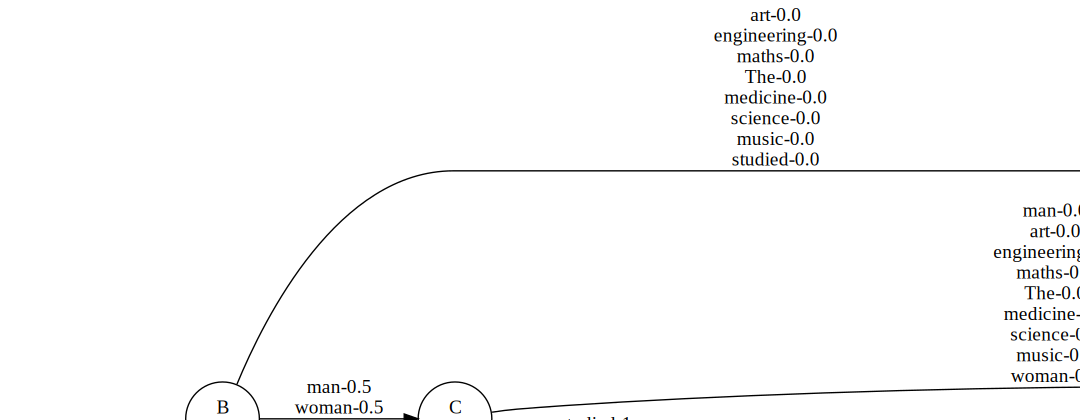

In [11]:
from pythautomata.model_exporters.dot_exporters.wfa_dot_exporting_strategy import WFADotExportingStrategy
from IPython.display import display

exporter = WFADotExportingStrategy()
graph = exporter.create_graph(property_model)

display(graph)

In [13]:
from utilities.syncronic_model_guided_language_model import SyncronicModelGuidedLanguageModel
synchronic_model = SyncronicModelGuidedLanguageModel(wrapper, property_model, model_name="GUIDED_BERT_SMALL", max_seq_length=10)

In [14]:
from pymodelextractor.teachers.pac_probabilistic_teacher import PACProbabilisticTeacher
from pymodelextractor.learners.observation_tree_learners.bounded_pdfa_quantization_n_ary_tree_learner import BoundedPDFAQuantizationNAryTreeLearner
from pythautomata.utilities.probability_partitioner import TopKProbabilityPartitioner, QuantizationProbabilityPartitioner, RankingPartitioner
from pythautomata.model_comparators.wfa_partition_comparison_strategy import WFAPartitionComparator
from pythautomata.utilities.uniform_word_sequence_generator import UniformWordSequenceGenerator
partitioner = QuantizationProbabilityPartitioner(100)
comparator = WFAPartitionComparator(partitioner)
epsilon = 0.1
delta = epsilon
sequence_generator = PDFASequenceGenerator(property_model, max_seq_length=10)
max_states = 10
max_query_length = 10


In [15]:
teacher  = PACProbabilisticTeacher(syncrhronic_model, epsilon = epsilon, delta = delta, max_seq_length = None, comparator = comparator, sequence_generator=sequence_generator, compute_epsilon_star=False)
learner = BoundedPDFAQuantizationNAryTreeLearner(partitioner, max_states, max_query_length, None, generate_partial_hipothesis = True, pre_cache_queries_for_building_hipothesis = True,  check_probabilistic_hipothesis = False)

In [16]:
learning_result = learner.learn(teacher, verbose=True)

ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).